In [1]:
import numpy as np
import matplotlib
#matplotlib.use('WebAgg')
#matplotlib.use('Qt4Cairo')
#matplotlib.use('Qt5Cairo')
matplotlib.use('nbAgg')
import matplotlib.pyplot as plt


from corridor import *
from path import path
from brains import brains
from evolution import individual, population



This is an example on how to use an evolving neural network to maximize the distance traveled in a corridor.
For this, the network takes as an input the coordinates of the walker (bob), and gives as output the angle of the next step. It is not the best way to do it, but it is a nice way to check if everythink else works.


The ultimate goal is create obstacles in the corridor, and train the network to avoid them. 
For this, I'll need to include a way to create abstacles in the corridor class (btw, I want to include many other functions, and it will become complicated to code without it being a class). Also, the input to the neural network will have to be complicated (probably check if there is an object near bob in many directions).



See the .py files for comments on the different classes. 

There are some things missisng, mainly in the population class. I need to mutate the next generation, and implement a better (propabilistic) breeding and survival of individuals.

I think that the individual class can be merged with brains, because it is realy usable in conjuction to brains.

I can train brains, in other ways, since the bains class is quite general. So, individual could be just a dirived class (because all indivuduals are brains but all brains are not individuals).


Also, the code needs optimization, but I belive it should be written in C++ if speed is the concern.

In [21]:
def score(x):
    '''
    calculate a score depending on the last x (how far it traveled without hitting a wall).
    '''
    
    return x
    

generation:  1  max:  3.226928875359848  mean:  0.16376665897187564


<IPython.core.display.Javascript object>


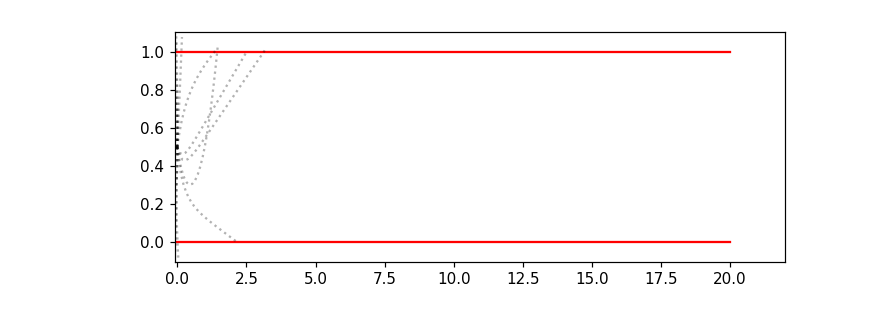

generation:  2  max:  3.226928875359848  mean:  0.463102977180531
generation:  3  max:  3.226928875359848  mean:  0.7131650381329042
generation:  4  max:  3.226928875359848  mean:  0.5818241040222283
generation:  5  max:  3.226928875359848  mean:  0.4613008702914114
generation:  6  max:  3.226928875359848  mean:  0.8760699453144503
generation:  7  max:  3.226928875359848  mean:  0.5970618517005122
generation:  8  max:  7.842719020963757  mean:  -0.6299524765373564
generation:  9  max:  7.842719020963757  mean:  1.58980532023907
generation:  10  max:  7.842719020963757  mean:  1.5924517067016537
generation:  11  max:  7.842719020963757  mean:  0.7217173167157973
generation:  12  max:  7.842719020963757  mean:  1.0307685978646266
generation:  13  max:  7.842719020963757  mean:  1.3940113679642032
generation:  14  max:  7.842719020963757  mean:  0.1854380319215498
generation:  15  max:  7.842719020963757  mean:  1.4680482802355617
generation:  16  max:  7.842719020963757  mean:  1.1490079

<IPython.core.display.Javascript object>


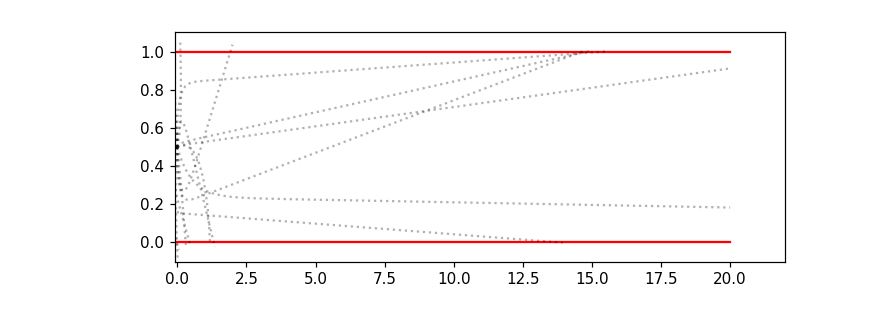

generation:  53  max:  20  mean:  4.111034052343332
generation:  54  max:  20  mean:  4.357675168969803
generation:  55  max:  20  mean:  3.579155763367416
generation:  56  max:  20  mean:  4.5613912740122045
generation:  57  max:  20  mean:  4.158272218848805
generation:  58  max:  20  mean:  4.370426790669965
generation:  59  max:  20  mean:  1.7795168612618006
generation:  60  max:  20  mean:  4.216971551296405
generation:  61  max:  20  mean:  3.845705196045975
generation:  62  max:  20  mean:  4.458189628183096
generation:  63  max:  20  mean:  3.8125836230912227
generation:  64  max:  20  mean:  3.6543009717086514
generation:  65  max:  20  mean:  4.20189716619676
generation:  66  max:  20  mean:  4.39444650369742
generation:  67  max:  20  mean:  5.1994452895677705
generation:  68  max:  20  mean:  4.45244028565404
generation:  69  max:  20  mean:  4.858386696246138
generation:  70  max:  20  mean:  4.12432395909206
generation:  71  max:  20  mean:  4.191973003576594
generation:

<IPython.core.display.Javascript object>


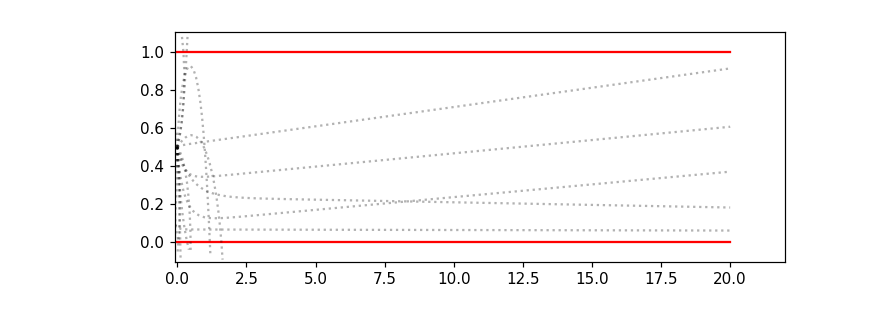

In [26]:
#Run the path moving according to brains evolved according to evolve


#initialize a corridor
cor=corridor(width=1,length=20)


runs=100#number of generations
_N=20#population size

_draw_every=50#draw path every '_draw_every' (+ the first and last)

#initialize a network
#lets take as an input x,y for now
ann=[brains(_inputs=2,_outputs=1,_layers=1,_hidden_nodes=[10]) for i in range(_N)]
for _n in range(_N):
    ann[_n].init_biases()
    ann[_n].init_weights()
    
#initialize the individuals
individuals=[individual(_brain=ind,_fitness_score=0) for ind in ann ]
#initialize population
P=population(_individuals=individuals,_size=_N,_survival_rate=5,_reproduction_rate=5)


_draw=0
for _generation in range(runs):
    paths=[]
    scores=[]
    #-------------------------------Run every individual-------------------------------#
    for _n in range(_N):
        #initialize a walker (bob) at some y0
        bob=path(y0=0.5)
        
        #--------------------Find the path of each individual------------------------#
        #move randomly (the movement will be decided by ann[_n]) 
        while True:
            in1,in2=bob.x[bob.steps],bob.y[bob.steps]

            ann[_n].read_input([in1,in2])
            ann[_n].feed_forward()

            bob.move(ann[_n].signals[-1][0]*np.pi,step=1e-1)
            
            #check if bob hit a wall
            check=cor.wall_detect(bob.x[-1],bob.y[-1])
            
            #add this step to the total distance traveled by bob
            bob.update_distance()
            
            #if bob traveled more than he should have exit the loop
            if bob.distance>4*cor.length:
                #print 'too much walking!'
                #print 'length of path: ',dist
                break

            if check=='Hit' or check=='Win' :
                #print check
                #print 'walked for: ', dist
                if check=='Win':
                    #if bob exited the corridor, set its last step to the 
                    #length of the corridor (the step is finite and I don't care for the accuracy of the path)
                    bob.x[-1]=cor.length
                break
        #-------------------------------------The path is found-------------------------#
        #append the path to a list 
        paths.append([bob.x,bob.y])
        
        # these are the final distances travelled (from x=0)
        _s=score(x=bob.x[-1])
        scores.append(_s)        
        individuals[_n].update_fitness_score(_s)#the score is the fitness score for the individual
    #-----------------------------------All paths found--------------------------------# 
    #rank all individuals    
    P.rank()
    #create the next generation
    P.new_generation()
    
    #print some results
    print 'generation: ', _generation+1, ' max: ',max(scores), ' mean: ',np.mean(scores)
    
    #the paths looks like this:
    if _draw == _draw_every or _generation==0 or _generation==runs-1:
        _draw=0
        cor.draw(runs,paths)
    else:
        _draw+=1


In [27]:
for i in enumerate(P.ranking):
    print i

(0, (1, 20))
(1, (2, 20))
(2, (6, 20))
(3, (11, 20))
(4, (15, 20))
(5, (4, 1.6374138853412075))
(6, (19, 1.1993662741919455))
(7, (13, 0.48194686720084146))
(8, (12, 0.4196214713831358))
(9, (16, 0.3683222635009967))
(10, (17, 0.16770482381479268))
(11, (18, 0.118463289494423))
(12, (5, 0.06220911371514979))
(13, (9, 0.003651819076219351))
(14, (8, -0.1612399027625765))
(15, (10, -0.23491019297407806))
(16, (0, -0.8909070586455434))
(17, (14, -0.9966932086810406))
(18, (7, -1.7035010198989))
(19, (3, -3.5381799102635223))
